In [1]:
import pandas as pd
from multiprocessing import Pool
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 10

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

In [2]:
# stim_ints = pd.read_csv('csvs/stimulus_intervals.csv', index_col=False)
# stim_ints['interval'] = stim_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
#                                                             pd.Timestamp(x.split(', ')[1].strip(')')), 
#                                                             closed='left'))

cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

bombus_visits = pd.read_csv('csvs/bombus_visit_durations.csv', index_col=False, parse_dates=['visit_start', 'visit_end'])
bombus_visits['interval'] = pd.IntervalIndex.from_arrays(bombus_visits['visit_start'], bombus_visits['visit_end'], closed='both')
bombus_visits

observed_values = bombus_visits['color'].value_counts()

In [3]:
bombus_clover = bombus_visits[bombus_visits['visit_end']<'2024-07-30']
bombus_visits = bombus_clover
observed_values = bombus_visits['color'].value_counts()

In [4]:
def run_simulation(cam_ints, bombus_visits):
    visit_dict = {}
    bombus_visits['pi'] = np.random.randint(1, 11, len(bombus_visits))

    color_counts = pd.Series(dtype=int)
    for i, visit in bombus_visits.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_ints[cam_ints['pi'] == pi]
        assigned = False

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': color}
                if color in color_counts:
                    color_counts[color] += 1
                else:
                    color_counts[color] = 1
                assigned = True
        if not assigned:
            visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': 'red'}

    return color_counts, visit_dict

visit_counts, visit_dict = run_simulation(cam_ints, bombus_visits)
print(f'total captured visits: {sum(visit_counts)}')
visit_counts


total captured visits: 254


yel    59
blu    51
grn    56
cnt    48
blv    40
dtype: int64

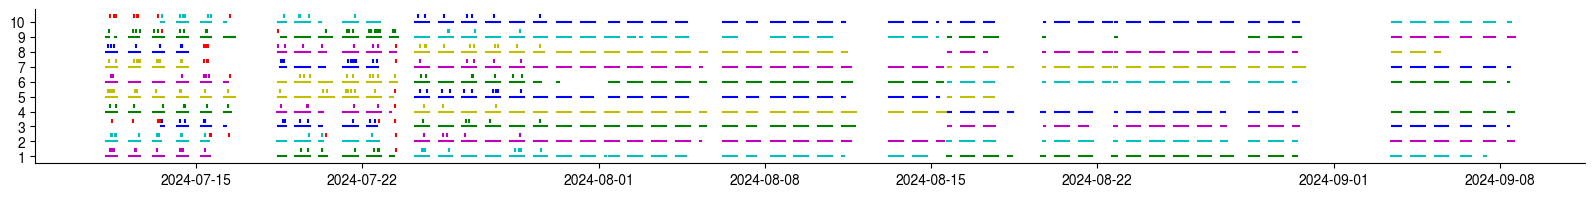

In [5]:
fig, ax = plt.subplots(figsize=(20, 2))
for i, row in cam_ints.iterrows():
    start = row['interval'].left
    end = row['interval'].right
    color = color_map[row['color']]
    pi = row['pi']
    ax.plot([start, end], [pi, pi], color=color)

for key, entry in visit_dict.items():
    visit_start = entry['visit_start']
    pi = entry['pi']
    color = color_map.get(entry['color'])
    ax.scatter(visit_start, pi+.4 , color=color, marker='|', s=10, zorder=3)

ax.set_yticks(np.arange(1,11))
ax.set_yticklabels(np.arange(1,11))
plt.show()

In [ ]:
def run_simulation(cam_on, visit_times, iterations=1):
    results = []

    for _ in range(iterations):
        visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
        color_counts = pd.Series(dtype=int)
        for _, visit in visit_times.iterrows():
            pi = visit['pi']
            visit_interval = visit['interval']
            relevant_cams = cam_on[cam_on['pi'] == pi]

            for _, cam in relevant_cams.iterrows():
                cam_interval = cam['interval']
                if visit_interval.overlaps(cam_interval):
                    color = cam['color']
                    color_counts[color] = color_counts.get(color, 0) + 1

        results.append(color_counts)

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T

    return final_results

# simulation_results = run_simulation(cam_ints, bombus_visits, iterations=1000)

In [6]:
from joblib import Parallel, delayed

def single_simulation(cam_on, visit_times):
    visit_times = visit_times.copy()
    visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
    color_counts = pd.Series(dtype=int)

    for _, visit in visit_times.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_on[cam_on['pi'] == pi]

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                color_counts[color] = color_counts.get(color, 0) + 1

    return color_counts

def run_simulation_parallel(cam_on, visit_times, iterations=1000, num_jobs=20):
    results = Parallel(n_jobs=num_jobs)(
        delayed(single_simulation)(cam_on, visit_times) for _ in range(iterations)
    )

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T
    return final_results

simulation_results_parallel = run_simulation_parallel(cam_ints, bombus_visits, iterations=10000)
simulation_results_parallel.to_csv('simresults_clover_10000_092125.csv', index=False)

In [7]:
simulation_results_parallel= pd.read_csv('simresults_clover_10000_092125.csv')
simulation_results_parallel

,cnt,yel,grn,blu,blv
0,53,55,59,40,44
1,61,52,53,43,45
2,50,51,52,41,54
3,54,54,53,41,46
4,50,53,61,41,48
...,...,...,...,...,...
9995,42,60,53,41,56
9996,58,55,58,40,42
9997,56,48,49,45,52
9998,53,48,60,41,45


In [8]:
observed_values

color
cnt    94
grn    70
blv    55
yel    36
blu    36
Name: count, dtype: int64

## Simulated distributions vs observed counts

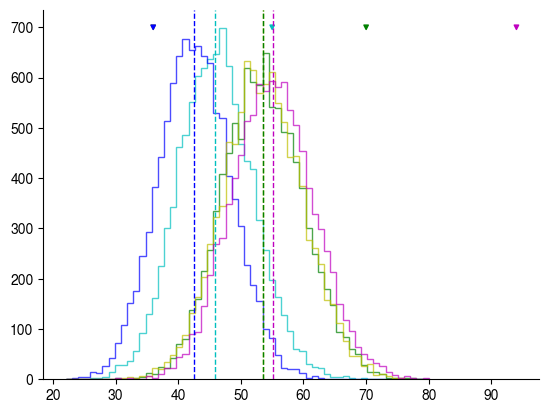

In [9]:
colors = [color_map[col] for col in simulation_results_parallel.columns]
plt.hist(simulation_results_parallel.values, bins=simulation_results_parallel.values.max() - simulation_results_parallel.values.min()+1, color=colors, histtype='step', alpha=0.7)
for col, color in zip(simulation_results_parallel.columns, colors):
    plt.axvline(simulation_results_parallel[col].mean(), color=color, linestyle='dashed', linewidth=1)

plt.scatter(observed_values.values, [700] * len(observed_values), 
           color=[color_map[color] for color in observed_values.index], s=10, marker='v')

plt.show()

In [10]:
from scipy import stats

sim_means = simulation_results_parallel.mean()
sim_sds = simulation_results_parallel.std()
pv_dict = {}

for idx in sim_means.index:
    z_score = (observed_values[idx] - sim_means[idx]) / sim_sds[idx]
    pv = 2 * (1 - stats.norm.cdf(abs(z_score)))  
    pv_dict[idx] = pv

pv_dict


{'cnt': 5.939520431041956e-09,
 'yel': 0.0074385773412697365,
 'grn': 0.012274493503567685,
 'blu': 0.2697031409106576,
 'blv': 0.13577587706201477}

## BLV - BLU simulated vs observed

In [11]:
simulation_results_parallel['blv-blu'] = simulation_results_parallel['blv'] - simulation_results_parallel['blu']

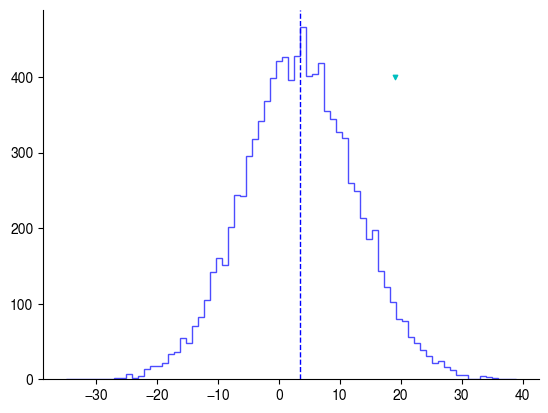

In [12]:
plt.hist(simulation_results_parallel['blv-blu'], bins=simulation_results_parallel['blv-blu'].max() - simulation_results_parallel['blv-blu'].min()+1, color='b', histtype='step', alpha=0.7)
plt.axvline(simulation_results_parallel['blv-blu'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.scatter(observed_values['blv'] - observed_values['blu'], 400, 
           color='c', s=10, marker='v')


plt.show()

In [13]:
sim_mean = simulation_results_parallel['blv-blu'].mean()
sim_sd = simulation_results_parallel['blv-blu'].std()
observed_value = observed_values['blv'] - observed_values['blu']

z_score = (observed_value - sim_mean) / sim_sd
pv = 1 - stats.norm.cdf(abs(z_score))

print(f'BLV-BLU p-value: {pv}')

BLV-BLU p-value: 0.04731610821798482


## CNT - mean(others)

In [25]:
simulation_results_parallel['cnt-all'] = simulation_results_parallel['cnt'] - simulation_results_parallel[['blu', 'yel', 'grn', 'blv']].mean(axis=1)

In [26]:
simulation_results_parallel['cnt-all'].max() - simulation_results_parallel['cnt-all'].min()+1

64.5

In [27]:
observed_values[['blu', 'yel', 'grn', 'blv']].mean()

50.25

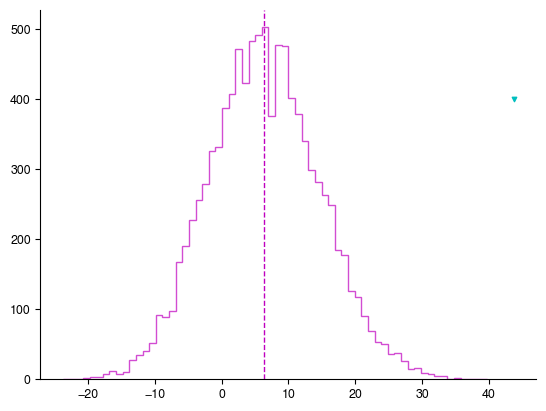

In [28]:
plt.hist(simulation_results_parallel['cnt-all'], bins=int(simulation_results_parallel['cnt-all'].max() - simulation_results_parallel['cnt-all'].min()+1), color='m', histtype='step', alpha=0.7)
plt.axvline(simulation_results_parallel['cnt-all'].mean(), color='m', linestyle='dashed', linewidth=1)

plt.scatter(observed_values['cnt'] - observed_values[['blu', 'yel', 'grn', 'blv']].mean(), 400, 
           color='c', s=10, marker='v')


plt.show()